# A basic facial recognition model using SVM and PCA

The next level after the recognizing digits using the MNIST data set is to
apply SVM's to facial recognition.

In this document we are using **scikit** libraries and samples to demonstrate
a basic approach to facial recognition; what we are seeing here is the first 
step towards learning **Computer Vision** which is done mostly with Deep CNN applied 
to advanced algorithms (like the YOLO family of Object detection algortithms) that we
will see in the next sessions in more detail.


# The dataset

In this example we are using a preprossesed and introduction friendly
dataset that can be downloaded from here:

http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz 

while the official site for it can be found here:

http://vis-www.cs.umass.edu/lfw/

Kaggle also provide a download if you like: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset

The dataset used in this example is a preprocessed excerpt of the “Labeled Faces in the Wild”, aka LFW:



In [1]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

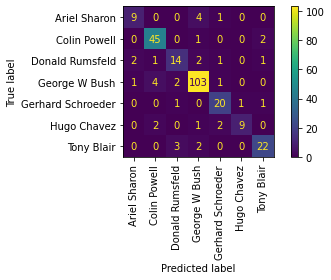

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
n_components = 150
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
t0 = time()
y_pred = clf.predict(X_test_pca)
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

# Predicting people based on unseen images

In [17]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


## Eigenfaces in Face Recognition

Determins the variance of faces in a collection of face images encoding the most important information to encode / decode a face without carrying the FULL information 
that is passed in a picture and by reducing the computation and space complexity.

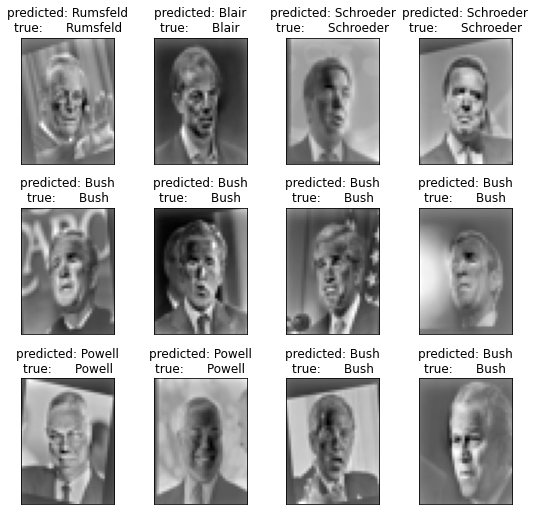

In [15]:
prediction_titles = [
    title(y_pred, 
          y_test, 
          target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

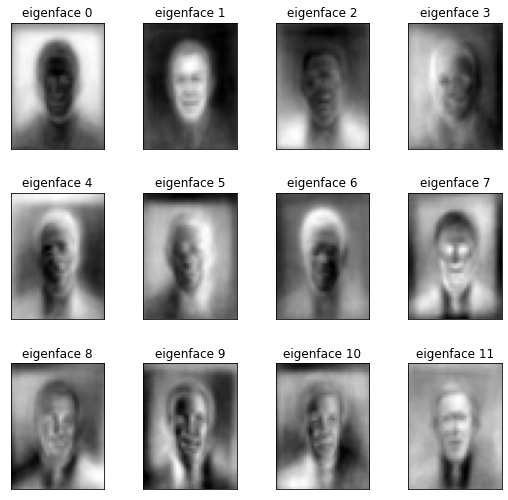

In [16]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()